## Preprocessing Google Trends data

This is the process we carry out before inserting new data into our database.

* The input data is received as a string with information about the batch (batch index) and the timeline data.
* The output is normalized datapoints for each keyword in the batch to be inserted into db.

### Step 1: parsing the data to identify batch index and timeline data

First let's have a look at the input string:

In [1]:
with open('./data/sample-plain-data.txt') as file:
    content = file.read()
    print(content[0:5])

B0___


In [2]:
content[0:500]

'B0___SEP___{"default":{"timelineData":[{"time":"1615446420","formattedTime":"Mar 11, 2021 at 7:07 AM","formattedAxisTime":"7:07 AM","value":[0,0,25,0,0],"hasData":[false,false,true,false,false],"formattedValue":["0","0","25","0","0"]},{"time":"1615446480","formattedTime":"Mar 11, 2021 at 7:08 AM","formattedAxisTime":"7:08 AM","value":[0,0,12,0,0],"hasData":[false,false,true,false,false],"formattedValue":["0","0","12","0","0"]},{"time":"1615446540","formattedTime":"Mar 11, 2021 at 7:09 AM","forma'

We use the `___SEP___` string as a separator to separate batch info from timeline data.

We use the `parser.parse_input_data` function to parse the data:

In [3]:
from packages.parser import parse_input_data
input_data = parse_input_data(content)

Let's have a look at out input data:

In [4]:
input_data['batch_index']

0

We can use this index to find the keywords in this batch.

In [5]:
input_data['averages']

[0, 0, 30, 1, 1]

This are the average Google search values for each keyword in the batch. The values are related to the maximum in this time window.

In [6]:
len(input_data['timeline'])

240

In [7]:
input_data['timeline'][0]

{'time': '1615446420',
 'formattedTime': 'Mar 11, 2021 at 7:07 AM',
 'formattedAxisTime': '7:07 AM',
 'value': [0, 0, 25, 0, 0],
 'hasData': [False, False, True, False, False],
 'formattedValue': ['0', '0', '25', '0', '0']}

The `timeline` property includes the actual values of the timeseries.

### Step 2: converting the data to Pandas DataFrame

To process the data, we first convert it to Pandas DataFrames. We use our `parser.convert_to_dataframe` method to do this. But first let's load our batches from redis. We use the `batches.load_batches_info` function to do so:

In [8]:
import redis
import os
from dotenv import load_dotenv
from packages.batches import load_batches_info

load_dotenv(dotenv_path='.env.notebooks')

True

In [9]:
REDIS_URI = os.environ.get('REDIS_URI')

In [10]:
batches_info = load_batches_info(REDIS_URI)

In [11]:
batches_info.keys()

dict_keys(['batches', 'categoryMap'])

We have the following information about each batch:

In [12]:
sample_batch = batches_info['batches'][0]

In [13]:
sample_batch

[{'term': '"Basis Cash"', 'category': '100-600'},
 {'term': '0chain', 'category': '100-600'},
 {'term': '1inch', 'category': '100-600'},
 {'term': '1INCH coin', 'category': '100-600'},
 {'term': '88mph', 'category': '100-600'}]

We also have the category to which each keyword belongs:

In [14]:
batches_info['categoryMap'][sample_batch[0]['term']]

'100-600'

Now we can convert our input data to Pandas DataFrame for further processing:

In [15]:
from packages.parser import convert_to_dataframe

In [16]:
df = convert_to_dataframe(input_data, batches_info['batches'])
df.head()

,"""Basis Cash""",0chain,1inch,1INCH coin,88mph,formattedValues,hasData,formattedTime,formattedAxisTime,time
timestamp,,,,,,,,,,
2021-03-11 07:07:00,0,0,25,0,0,0-0-25-0-0,N-N-Y-N-N,"Mar 11, 2021 at 7:07 AM",7:07 AM,1615446420
2021-03-11 07:08:00,0,0,12,0,0,0-0-12-0-0,N-N-Y-N-N,"Mar 11, 2021 at 7:08 AM",7:08 AM,1615446480
2021-03-11 07:09:00,0,0,50,0,0,0-0-50-0-0,N-N-Y-N-N,"Mar 11, 2021 at 7:09 AM",7:09 AM,1615446540
2021-03-11 07:10:00,0,0,12,0,0,0-0-12-0-0,N-N-Y-N-N,"Mar 11, 2021 at 7:10 AM",7:10 AM,1615446600
2021-03-11 07:11:00,0,0,36,0,0,0-0-36-0-0,N-N-Y-N-N,"Mar 11, 2021 at 7:11 AM",7:11 AM,1615446660


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='timestamp'>

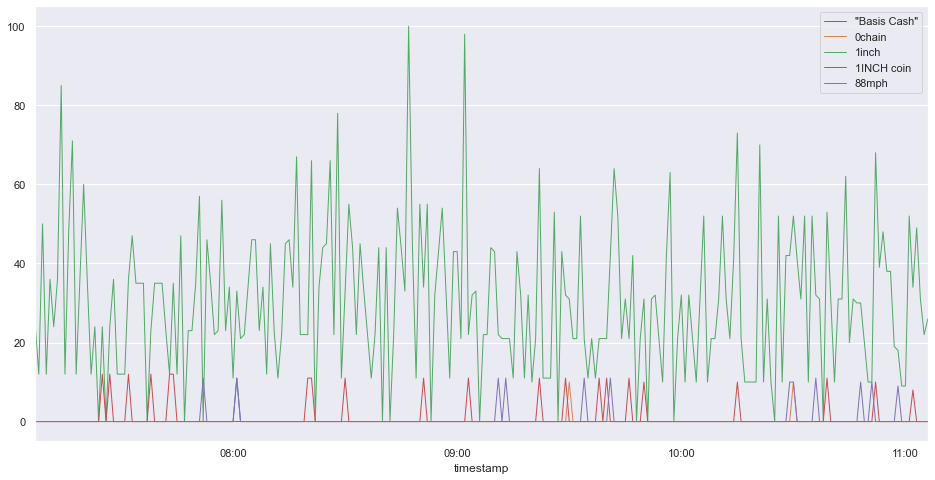

In [18]:
sns.set(rc={'figure.figsize':(16, 8)})
df.plot(linewidth=1)